## Maximum a Posteriori Introduction

In this notebook, we introduce the Maximum a Posteriori (MAP), which extends Maximum Likelihood Estimation (MLE) by inclusion of a prior $p(\theta)$ into the cost function. This becomes a Bayesian method, and follows the Bayesian Theorem given as,

$$
P(\theta|D) = \frac{P(D|\theta)P(\theta)}{P(D)}
$$

where,

$P(\theta|D)$ represents the posterior and can be read as "the probability of the parameters $(\theta)$ given the data $(D)$", 

$P(D|\theta)$ is the probability of the data given the parameters, commonly called the likelihood, 

$P(\theta)$ represents the probability of the parameters commonly called the prior,

$P(D)$ is the probability of the data and is commonly called the marginal probability.

However, as the marginal probability is commonly difficult to compute and represents a normalisation constant, in the case of MAP this term is forgone and the proportional posterior is optmised instead. This is given as,

$$
P(\theta|D) \propto P(D|\theta)P(\theta)
$$

### Setting up the Environment

Before we begin, we need to ensure that we have all the necessary tools. We will install and import PyBOP as well as upgrade dependencies. We also fix the random seed in order to generate consistent output during development, although this does not need to be done in practice.

In [ ]:
%pip install --upgrade pip ipywidgets -q
%pip install pybop -q

import time

import numpy as np

import pybop

np.random.seed(8)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


### Creating the model

To demonstrate the MAP process, we will first need a forward model and data to run parameter inference on. As we are introducing this as a simple example, we will use the PyBOP forward model with white noise as the reference. This requires defining a parameter set and the model itself.

In [ ]:
parameter_set = pybop.ParameterSet.pybamm("Chen2020")
# parameter_set.update(
#     {
#     "Positive electrode active material volume fraction": 0.6,
#     "Negative electrode active material volume fraction": 0.6,
#     }
# )
model = pybop.lithium_ion.SPM(parameter_set=parameter_set)

### Simulating Forward Model

We can now simulate the model using the `model.predict` method. This method is a light wrapper on the `Pybamm.Simulation` class and be used as such. For this example, we use the default current function for the `Chen2020` parameter set (5A) to generate the voltage data. As the goal is to investigate the MAP method, we will generate a range of observations from the forward model. 

In [ ]:
n = 8  # Number of time-series trajectories
observations = [
    2**j for j in range(1, n + 1)
]  # Number of observations in each trajectory
values = []
for i in observations:
    t_eval = np.linspace(0, 10, i)
    values.append(model.predict(t_eval=t_eval))  # predict and store

### Adding noise to synthetic voltage data

To make the parameter inference more realistic, we add gaussian noise with zero mean to the data. While this doesn't truly represent the challenge of parameter inference with experimental data, this does ensure the cost landscape curvature isn't perfect. For a more realistic representation of experimental data, a different noise function could be used. 

In [ ]:
sigma = 0.001
corrupt_values = values[1]["Voltage [V]"].data + np.random.normal(
    0, sigma, len(values[1]["Voltage [V]"].data)
)

### Creating the PyBOP dataset

The reference trajectory needs to be included in the optimisation task, which is handed within the `Dataset` class. In this situation, this class is composed of the time, current, and the noisy voltage data; however, if we were completing parameter inference from a different measured signal, such as 'Cell Temperature', that would need to be included.

In [ ]:
dataset = pybop.Dataset(
    {
        "Time [s]": values[1]["Time [s]"].data,
        "Current function [A]": values[1]["Current [A]"].data,
        "Voltage [V]": corrupt_values,
    }
)

### Constructing Parameters Class
Next, we need to select the forward model parameters for inference. The PyBOP parameters class composes as many PyBOP parameter classes as the user wants (whether that is a good idea is left out of this example). This class requires the parameter name, which must resolve to a parameter within the `ParameterSet` defined above. Additionally, this class can accept an `initial_value` which will be used by the optimiser, as well as bounds. For this example, we will provide a `prior` to the parameter class, which will be used later by the MAP process.

In [ ]:
parameters = pybop.Parameters(
    pybop.Parameter("Negative particle radius [m]", prior=pybop.Gaussian(4e-6, 1e-6)),
    pybop.Parameter("Positive particle radius [m]", prior=pybop.Gaussian(5e-6, 1e-6)),
)

Default bounds applied based on prior distribution.
Default bounds applied based on prior distribution.


### Setting up the Fitting Problem, Likelihood, and Posterior

With the datasets and parameters defined, we can now construct the `FittingProblem` which composes the model, parameters, and dataset providing a single class with the required information for simulating and assessing the forward model. 

As described in the introduction to this notebook, the MAP method uses the pre-normalised posterior for optimisation. This is defined in PyBOP as the `LogPosterior` class, and has arguments for the likelihood and prior functions. If a prior is not provided, the parameter priors are used as default. In this example, we will use a `GaussianLogLikelihood` likelihood function, and the default priors set above. For numerical reasons, we optimise the log of the posterior; however this doesn't affect the final results.

In [ ]:
problem = pybop.FittingProblem(model, parameters, dataset)
likelihood = pybop.GaussianLogLikelihood(problem)
posterior = pybop.LogPosterior(likelihood)

### Plotting the Posterior components

Next, to investigate the individual components of the Posterior. The `LogPosterior` class provides attributes of the prior and likelihood. To investigate the contributions of each to the Posterior we plot the landscapes across a selected parameter range.

Fixed Sigma for output 1: 0.02


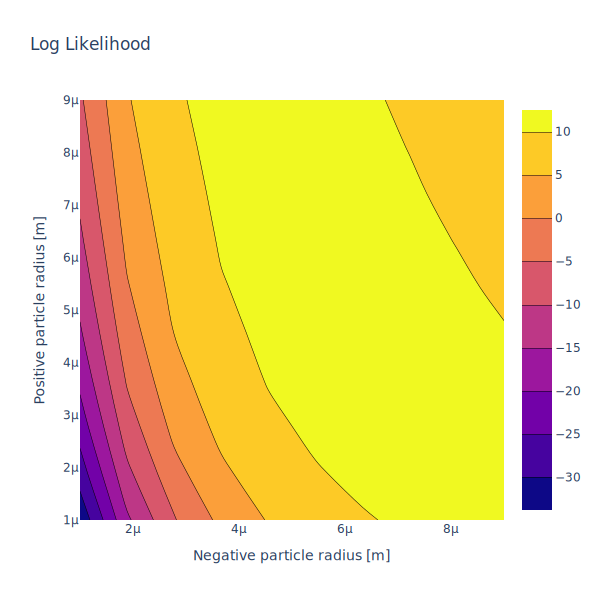

Fixed Sigma for output 1: 0.02


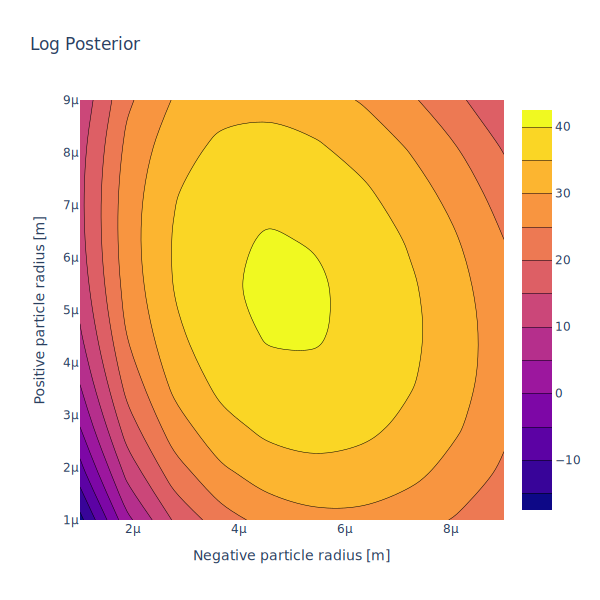

In [ ]:
steps = 10  # Number of discretisation points
bounds = np.asarray([[1e-6, 9e-6], [1e-6, 9e-6]])
# pybop.plot2d(posterior.prior, bounds=bounds, steps=steps, title="Log Prior")
pybop.plot2d(posterior.likelihood, bounds=bounds, steps=steps, title="Log Likelihood")
pybop.plot2d(posterior, bounds=bounds, steps=steps, title="Log Posterior");

As expected, the prior represents a two-dimensional gaussian distribution with a maximum at $[4e-6,5e-6]$. The likelihood appears to have a banded shape with ridge of optimal points traversing the higher parameter values. Finally, the Posterior forms the combination of the two. This is the benefit of the MAP process, as it allows for previous information to be included in the parameter inference task. Previous knowledge is encapsulated within the prior function and influences the Posterior, depending on the magnitude of the likelihood function.

To show how this is used within a PyBOP optimisation task, we select the Covariance Matrix Adaptation Evolution Strategy optimiser and run the optimisation. We can then plot the parameter trajectories to investigate how the optimiser performed.

Inferred Parameters: [5.25024312e-06 5.56438314e-06 1.00120476e-02] in 16.73701000213623 seconds


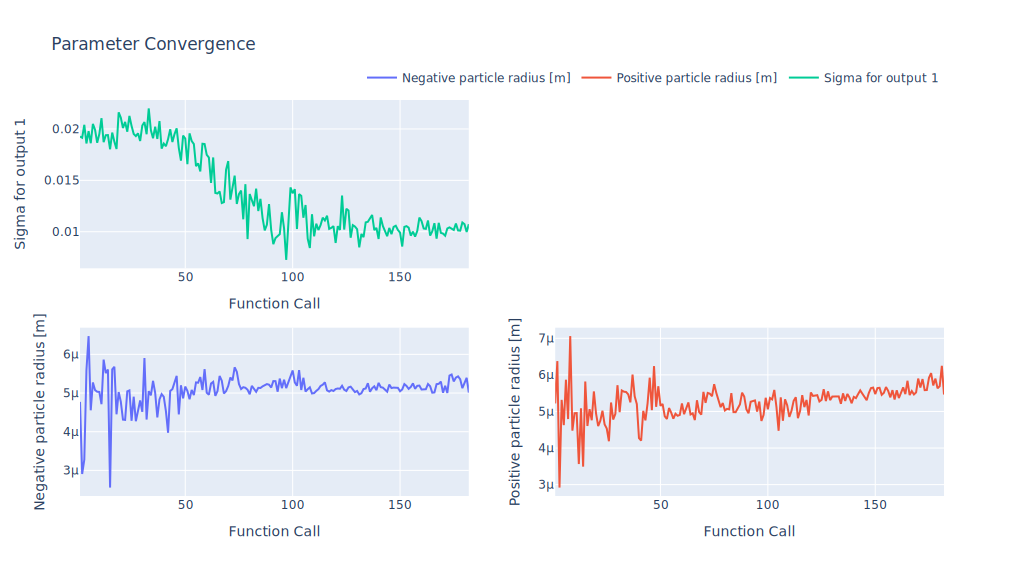

In [ ]:
optim = pybop.XNES(
    posterior, min_iterations=20, max_iterations=100, sigma0=[1e-6, 1e-6, 1e-3]
)
start_time = time.time()
x, final_cost = optim.run()
print(f"Inferred Parameters: {x} in {time.time() - start_time} seconds")
pybop.plot_parameters(optim);

## Investigating how the number of observations effects the Posterior

We've seen above that the proportional posterior can be represented from its components, the log-likelihood and log-prior. Next, to better understand when each of these terms can become dominating within the parameter inference problem we vary the number of measurement observations (i.e. the number of samples in the dataset) and inspect the construct posterior.

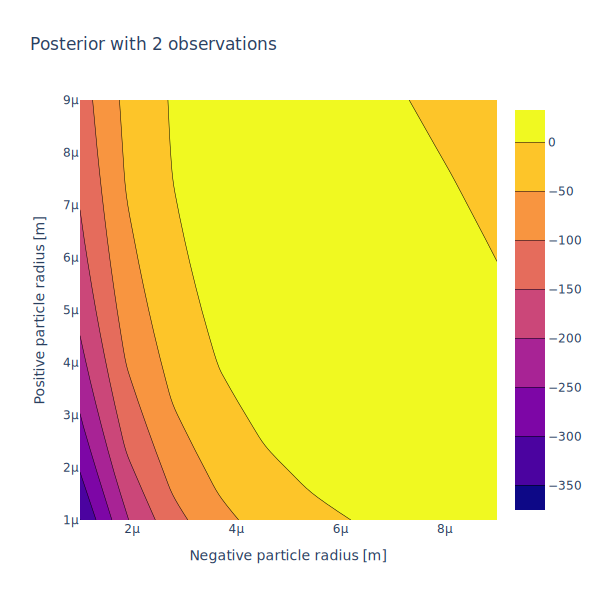

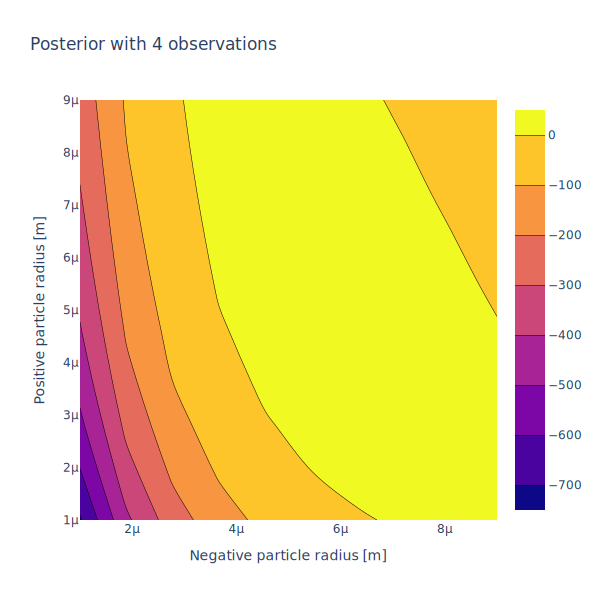

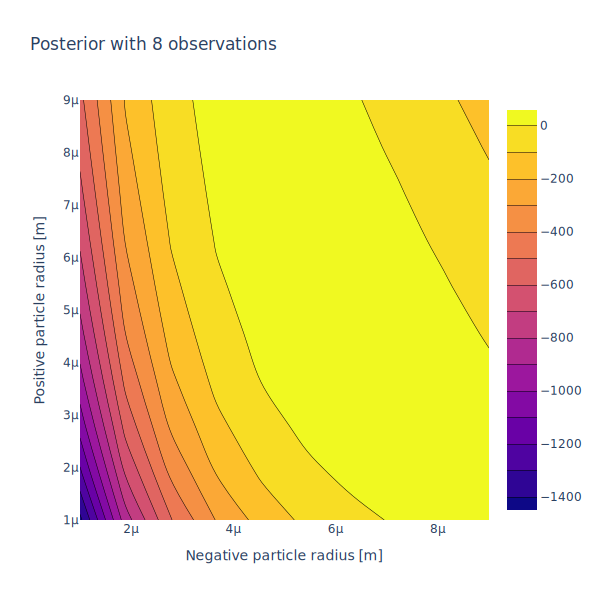

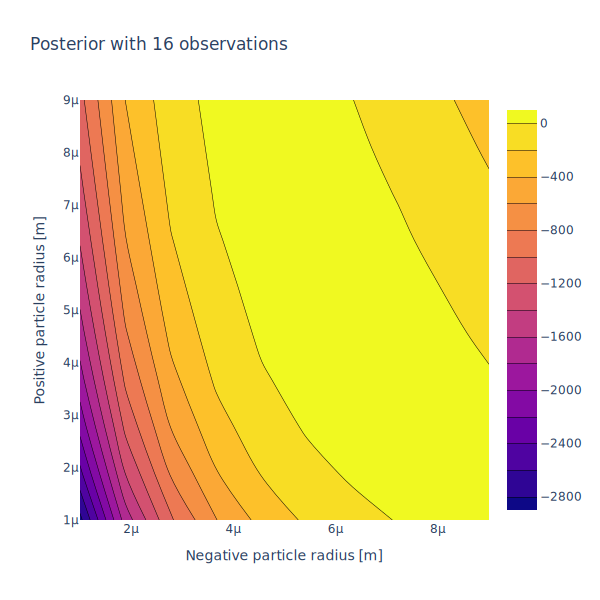

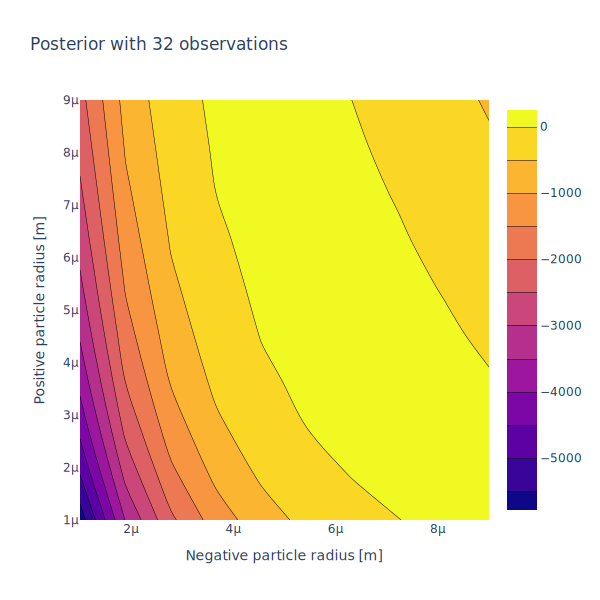

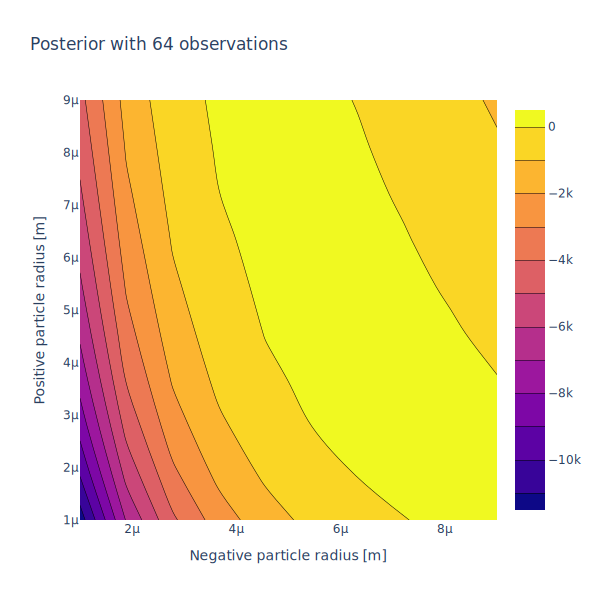

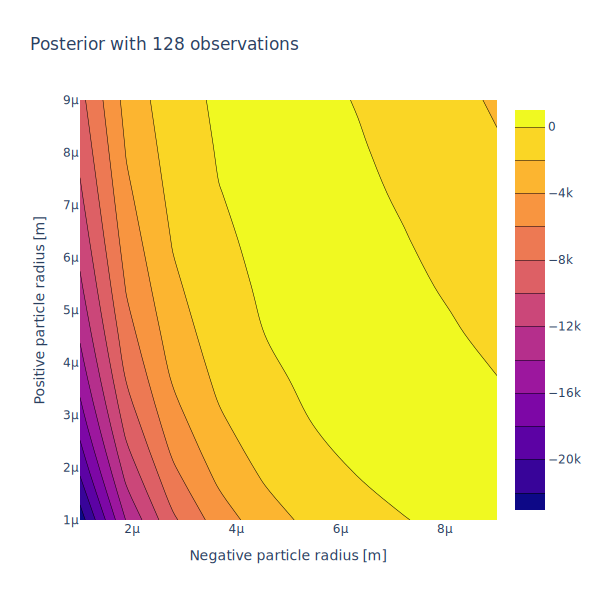

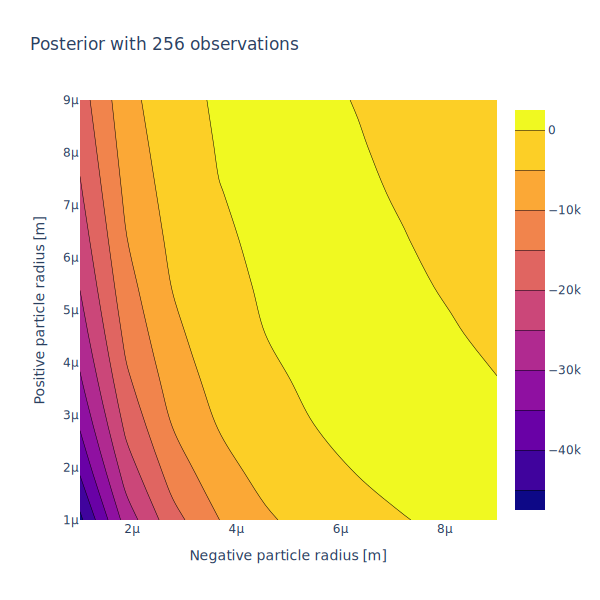

In [ ]:
for i, val in enumerate(values):
    dataset = pybop.Dataset(
        {
            "Time [s]": val["Time [s]"].data,
            "Current function [A]": val["Current [A]"].data,
            "Voltage [V]": val["Voltage [V]"].data
            + np.random.normal(0, sigma, len(val["Voltage [V]"].data)),
        }
    )
    # problem.set_target(dataset)
    problem = pybop.FittingProblem(model, parameters, dataset)
    likelihood = pybop.GaussianLogLikelihoodKnownSigma(problem, sigma0=0.005)
    cost = pybop.LogPosterior(likelihood)
    pybop.plot2d(
        cost,
        bounds=bounds,
        steps=steps,
        title=f"Posterior with {observations[i]} observations",
    )

### Conclusion

This notebook illustrates how to perform parameter estimation using AdamW in PyBOP, providing insights into the optimisation process through various visualisations.